## Topic Modelling Analysis of FakeDisorderCringe

Import necessary libraries

In [1]:
import re
from pprint import pprint
from unidecode import unidecode
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import datetime
import platform
from importlib.metadata import version

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatisation
import spacy

# Plotting NLP tools
import pyLDAvis
import pyLDAvis.gensim 

In [2]:
# Enable logging for gensim - optional
import logging
logging.basicConfig(filename = '/home/main/data/FakeDisorderCringe/gensim.log',
                    format = "%(asctime)s:%(levelname)s:%(message)s",
                    level = logging.DEBUG)

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['xa', 'xe', 'ehm', 'like', 'kinda', 'eh', 'yeah', 'mm', 'https', 'com'])

# For normalisation
import textacy
from textacy import preprocessing

In [3]:
data_file = "/home/main/data/FakeDisorderCringe/fakedisordercringe_comments"

excluded_posts = ["[deleted]", "[removed]", "good bot", "bad bot"]
custom_bots_list = {"AutoModerator", "VredditDownloader", "dadbot_2", "B0tRank", "uwuwizard", "auto-xkcd37", "cookie_b0t", "generic_reddit_bot_2"}

# Parallel processing
multicore = True

# For reproducibility
random_seed = 7550822

# For plotting posting over time
post_dates = []

total_post_count = 0

Pre-processing and normalisation functions

In [4]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|\(https?://\S+\)')
    cleaned_text = re.sub(url_pattern, '', text)
    return(cleaned_text)

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatisation(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN']):
    texts_out = []

    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def read_process_textfile(filename):
    processed_words = []
    bots_list = []

    with open(data_file, 'r') as file:
        for line in file:
            try:
                data = json.loads(line)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
                continue

            # Increment total post count
            global total_post_count
            total_post_count += 1

            # Check for bots, exclude by continue, and add to bot list
            # Any of the custom_bot_list
            username_str = data["author"]
            if username_str in custom_bots_list:
                bots_list.append(username_str)
                continue
            # Any usernames ending in 'bot' but not 'robot'
            if username_str.lower().endswith('bot') and not username_str.lower().endswith('robot'):
                bots_list.append(username_str)
                continue

            # Get comment body
            body_str = data["body"].lower()

            # Remove any deleted, removed posts or bot rating posts
            if any(exclusion in body_str for exclusion in excluded_posts):
                continue

            # Normalise / clean text etc
            body_str = remove_urls(body_str)
            body_str = preprocessing.normalize.unicode(body_str)
            body_str = preprocessing.remove.accents(body_str)
            body_str = preprocessing.normalize.quotation_marks(body_str)

            spchars = re.compile(
                '\…\`|\~|\!|\@|\#|\$|\%|\^|\&|\*|\(|\)|\_|\+|\=|\\|\||\{|\[|\]|\}|\:|\;|\'|\"|\<|\,|\>|\?|\/|\.|\-')
            body_str = spchars.sub(" ", body_str)
            body_str = re.sub('\s{2,}', ' ', body_str)

            # Add line to processed corpus
            processed_words.append(body_str)
            
            # Store date if the included comment date to the post_dates list
            post_utc_str = data["created_utc"]
            post_utc_int = int(post_utc_str)
            post_dt_object = datetime.datetime.fromtimestamp(post_utc_int)
            post_dates.append(post_dt_object)

        print("Posts removed from the following probable bots:")
        unique_bots = (list(set(bots_list)))
        print(*unique_bots, sep = "\n")

    # Write processed text file for inspection
    with open(r'/home/main/Dropbox/data/FakeDisorderCringe/fdc_postprocessing.txt', 'w') as fp:
        fp.write('\n'.join(processed_words))

    return(processed_words)

Pre-process and normalise text, remove stop words

In [5]:
# Process text file
data_words = read_process_textfile(data_file)

# Remove stop words
data_words_nostops = remove_stopwords(data_words)

Posts removed from the following probable bots:
useles-converter-bot
WizziBot
same_subreddit_bot
xkcd-Hyphen-bot
EmojifierBot
LOGANG-BOT
Blasterbot
same_post_bot
AmputatorBot
YoMommaJokeBot
auto-xkcd37
ReverseCaptioningBot
cookie_b0t
69_Nice_Bot
VenoBot
noorubot
cescapsybot
iamabotbotbot
ThesaurizeThisBot
RatedCommentBot
notjustanotherbot
exclaim_bot
Clunkbot
UkraineWithoutTheBot
redditspeedbot
AmongUsDongBot
Upside_Down-Bot
Lolli_bot
Ztormiebotbot
queen_of_england_bot
RepostSleuthBot
Satabic_Sabbot
NoGoogleAMPBot
twitterInfo_bot
probably_just_a_bot
Wa1lterbot
uwuwizard
BadDadBot
emojifyemojifier_bot
FatFingerHelperBot
Dec_bot
B0tRank
SoulsLikeBot
RedditMP4Bot
hotlinehelpbot
VredditDownloader
JustAnAlpacaBot
whole_alphabet_bot
NaotoBot
SomaliNotSomalianbot
Paid-Not-Payed-Bot
and-my-axe-bot
Obnoxiousnessbot
WaterIsWetBot
Generic_Reddit_Bot
Reddit-Book-Bot
norawbot
megzybot
yogobot
Not_RepostSleuthBot
converter-bot
The_Dapperbot
TBFP_BOT
RockinTheKevbot
answer-reddit-bot
sneakpeekbot
are

Descriptive stats on forum posting

Earliest post date: 2020-08-20 18:47:13
Latest post date: 2022-12-31 23:58:40
Number of posts pre-processing: 991963
Number of posts post-processing: 850274


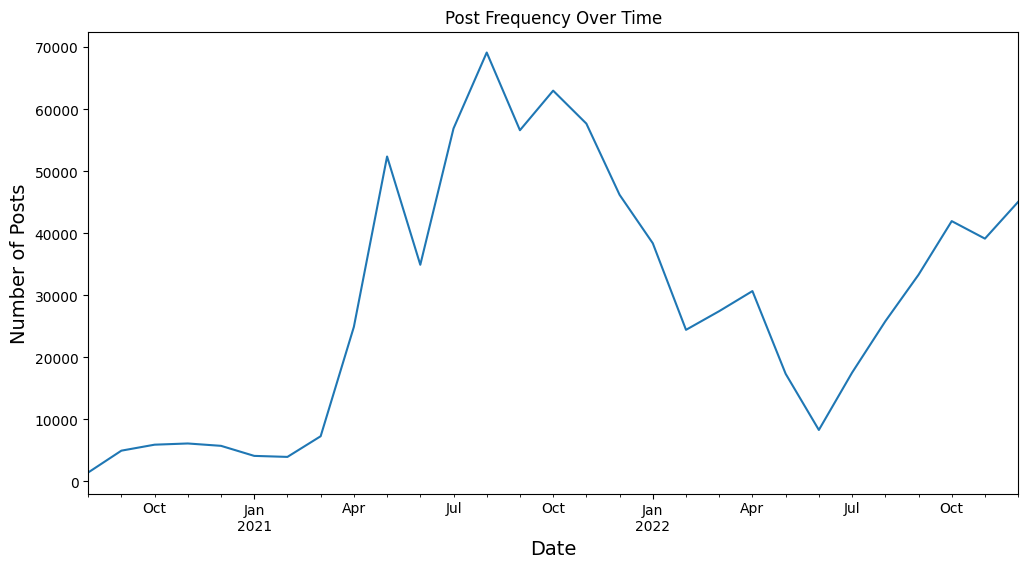

In [6]:
# Convert the Series to a pandas DatetimeIndex
posts = pd.Series(post_dates)
posts_index = pd.DatetimeIndex(posts.values)

# Sort and resample by month
posts_freq = posts_index.to_series().sort_index().resample('M').size()

print(f"Earliest post date: {posts_index.min()}")
print(f"Latest post date: {posts_index.max()}")
print(f"Number of posts pre-processing: {total_post_count}")
print(f"Number of posts post-processing: {len(posts_index)}")

posts_freq = posts_index.to_series().sort_index().resample('M').size()
posts_freq.plot(kind='line', figsize=(12, 6), title='Post Frequency Over Time')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Posts', fontsize=14)
plt.show()

Create bigram / trigram models

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words_nostops, min_count = 5, threshold = 100)
trigram = gensim.models.Phrases(bigram[data_words_nostops], min_count = 5, threshold = 100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Form bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

Lemmatisation

In [8]:
# Initialise spacy 'en_core_web_md' (medium model), keeping only tagger component (for efficiency)
# python3 -m spacy download en_core_web_md
# Use en_core_web_sm for a smaller model
nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])

# Do lemmatisation keeping only noun, adj, vb, adv
data_lemmatized = lemmatisation(data_words_bigrams, allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV'])

Create dictionary and corpus

In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create corpus
texts = data_lemmatized

# Term document frequency
corpus = [id2word.doc2bow(text) for text in texts]

Iterative topic modelling, storing coherence scores for each topic solution

In [10]:
# Define model for parallel processing (if multicore is True)
if multicore:
    Lda = gensim.models.LdaMulticore
else:
    Lda = gensim.models.ldamodel.LdaModel

In [11]:
# Model with n to n topics and store coherence score for each
coherence = []
perplexity = []
for k in range(5, 31):
    print('Modelling with topics = ' + str(k))
    ldamodel = Lda(corpus = corpus, id2word = id2word,
                   num_topics = k,
                   chunksize = 5000, passes = 50, iterations = 500, 
                   random_state = random_seed,
                   per_word_topics = True)
    
    cm = gensim.models.coherencemodel.CoherenceModel(
         model = ldamodel, texts = data_lemmatized,
         dictionary = id2word, coherence = 'c_uci')
                                                
    coherence.append((k, cm.get_coherence()))

    doc_lda = ldamodel[corpus]
    topics_tmp = ldamodel.print_topics()

    file_stem = "/home/main/Dropbox/data/FakeDisorderCringe/topics_output"
    file_str = file_stem + str(k) + ".txt"
    with open(file_str, 'w') as file:
        for topic in topics_tmp:
            file.write(f"{topic}\n")

num_topics, coherence_scores = zip(*coherence)

Modelling with topics = 5
Modelling with topics = 6
Modelling with topics = 7
Modelling with topics = 8
Modelling with topics = 9
Modelling with topics = 10
Modelling with topics = 11
Modelling with topics = 12
Modelling with topics = 13
Modelling with topics = 14
Modelling with topics = 15
Modelling with topics = 16
Modelling with topics = 17
Modelling with topics = 18
Modelling with topics = 19
Modelling with topics = 20
Modelling with topics = 21
Modelling with topics = 22
Modelling with topics = 23
Modelling with topics = 24
Modelling with topics = 25
Modelling with topics = 26
Modelling with topics = 27
Modelling with topics = 28
Modelling with topics = 29
Modelling with topics = 30


Plot coherence scores

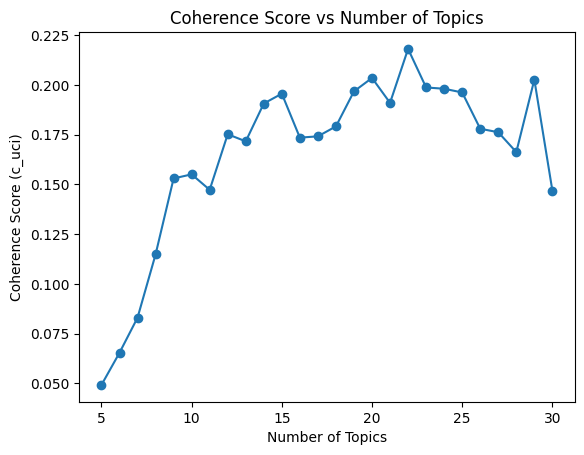

In [12]:
# Plot graph of coherence by number of topics
plt.plot(num_topics, coherence_scores, marker = 'o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score (c_uci)')
plt.title('Coherence Score vs Number of Topics')
plt.show()

Show 15 topic solution

In [13]:
# Build LDA model and run for number of topics with best coherence scores
# 15 topics
print("Build topic model ...")

lda_model = Lda(corpus = corpus,
                id2word = id2word,
                num_topics = 15,
                random_state = random_seed,
                chunksize = 5000,
                passes = 50,
                iterations = 500,
                per_word_topics = True)

Build topic model ...


In [14]:
# Visualise the topics
pyLDAvis.enable_notebook()
vis_15_topics = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis_15_topics

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.070558  0.064622       1        1  11.321390
10     0.128879  0.093697       2        1  11.025894
0     -0.071368  0.126770       3        1  10.044757
11     0.076442  0.107736       4        1   9.041662
1     -0.119967  0.130605       5        1   7.265332
2      0.180553 -0.045544       6        1   6.798548
7      0.056871  0.104275       7        1   6.086091
6     -0.065212 -0.030125       8        1   5.910799
8      0.104308 -0.051974       9        1   5.623248
5      0.102270 -0.012896      10        1   5.557405
9      0.086054 -0.148628      11        1   5.420472
14     0.102287 -0.109779      12        1   4.467254
4     -0.114766 -0.064384      13        1   4.048272
12    -0.326372  0.095514      14        1   3.776853
13    -0.210536 -0.259889      15        1   3.612023, topic_info=         Term           Freq          Total Category  logprob  loglift
20       fake   70524.000000   70524.000000  Default  30.0000  30.0000
250     alter   51411.000000   51411.000000  Default  29.0000  29.0000
31     people  197208.000000  197208.000000  Default  28.0000  28.0000
118  disorder   77847.000000   77847.000000  Default  27.0000  27.0000
57        see   72888.000000   72888.000000  Default  26.0000  26.0000
..        ...            ...            ...      ...      ...      ...
89      think    4489.895384  101882.213848  Topic15  -4.3880   0.1989
145      look    3535.788232   46288.041009  Topic15  -4.6269   0.7490
242   pretend    2220.339148   10270.059128  Topic15  -5.0922   1.7893
67        get    3667.790312  131391.035263  Topic15  -4.5902  -0.2577
16      watch    2132.581126   13961.578807  Topic15  -5.1325   1.4419

[1090 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
3343      2  0.991462  abandonment
2646      1  0.000454      ability
2646      2  0.842515      ability
2646      4  0.111336      ability
2646      6  0.044534      ability
...     ...       ...          ...
764       6  0.112188        young
764      11  0.053313        young
764      12  0.000288        young
244       8  0.999385      youtube
6094      2  0.991425       zoning

[3052 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 11, 1, 12, 2, 3, 8, 7, 9, 6, 10, 15, 5, 13, 14])

In [15]:
# Optimise words for exclusivity to topic using tuned lambda value
all_topics = {}
num_terms = 10
lamda_val = 0.6
for i in range(1,16): #Adjust this to reflect number of topics chosen for final LDA model
    topic = vis_15_topics.topic_info[vis_15_topics.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lamda_val)+topic['logprob']*lamda_val
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

pd.DataFrame(all_topics).T

,0,1,2,3,4,5,6,7,8,9
Topic 1,people,attention,faker,want,community,hate,fake,internet,see,make
Topic 2,trauma,experience,brain,cause,abuse,feel,thing,way,situation,happen
Topic 3,kid,friend,year,day,go,parent,school,old,get,child
Topic 4,diagnose,diagnosis,self,doctor,adhd,get,help,therapist,professional,test
Topic 5,hand,eye,head,face,hair,look,wear,get,walk,sleep
Topic 6,disorder,symptom,research,study,rare,source,case,base,information,medical
Topic 7,mental,illness,disorder,fun,make,quirky,anxiety,health,depression,ocd
Topic 8,video,see,tiktok,watch,say,comment,first,ask,hear,ever
Topic 9,autistic,autism,word,thank,mean,stim,stimming,speak,understand,people
Topic 10,fake,tic,know,pretty,tourette,sure,song,seem,think,sign


Show 20 topic solution

In [16]:
# Build LDA model and run for number of topics with best coherence scores
# 20 topics
print("Build topic model ...")

lda_model = Lda(corpus = corpus,
                id2word = id2word,
                num_topics = 20,
                random_state = 100,
                chunksize = 5000,
                passes = 50,
                iterations = 500,
                per_word_topics = True)

Build topic model ...


In [17]:
# Visualise the topics
pyLDAvis.enable_notebook()
vis_20_topics = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis_20_topics

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
14    -0.130326 -0.089383       1        1  9.658418
16    -0.092005 -0.047522       2        1  7.549371
9      0.092253 -0.198841       3        1  7.037165
15    -0.169414 -0.018058       4        1  6.972827
3     -0.039997  0.054970       5        1  6.695219
0     -0.056207  0.010020       6        1  6.235994
8     -0.134636 -0.041655       7        1  6.197514
5     -0.012126 -0.165466       8        1  5.907662
18     0.108496 -0.211876       9        1  5.220717
17     0.117452 -0.119980      10        1  5.008553
12     0.032014  0.071316      11        1  4.294359
7      0.014859  0.126805      12        1  3.941614
4     -0.124581  0.101488      13        1  3.761160
10    -0.117578  0.118300      14        1  3.631103
19     0.169155  0.090635      15        1  3.451203
11    -0.023606 -0.007168      16        1  3.279757
13    -0.125539  0.214398      17        1  3.076763
6     -0.065195 -0.099723      18        1  3.045225
1      0.284356  0.090641      19        1  2.716204
2      0.272625  0.121098      20        1  2.319171, topic_info=          Term          Freq          Total Category  logprob  loglift
118   disorder  79352.000000   79352.000000  Default  30.0000  30.0000
89       think  99669.000000   99669.000000  Default  29.0000  29.0000
250      alter  51210.000000   51210.000000  Default  28.0000  28.0000
194   diagnose  50795.000000   50795.000000  Default  27.0000  27.0000
20        fake  68932.000000   68932.000000  Default  26.0000  26.0000
...        ...           ...            ...      ...      ...      ...
145       look   3425.940354   46560.017780  Topic20  -4.2154   1.1546
1305    animal   1048.651298    2388.017295  Topic20  -5.3993   2.9410
10        make   1667.055669  104841.135708  Topic20  -4.9357  -0.3774
67         get   1611.339079  131741.184448  Topic20  -4.9697  -0.6398
27        want   1057.227918   53204.656965  Topic20  -5.3911  -0.1545

[1389 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
24597      6  0.987815      aave
2405       1  0.080388   ableist
2405       5  0.008731   ableist
2405       6  0.874337   ableist
2405       7  0.036431   ableist
...      ...       ...       ...
244       12  0.079927   youtube
244       20  0.122520   youtube
245       12  0.998920  youtuber
1588      18  0.998855      zone
14156      2  0.984526       zoo

[4398 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 17, 10, 16, 4, 1, 9, 6, 19, 18, 13, 8, 5, 11, 20, 12, 14, 7, 2, 3])

In [18]:
# Optimise words for exclusivity to topic using tuned lambda value
all_topics = {}
num_terms = 10
lamda_val = 0.6
for i in range(1,21): #Adjust this to reflect number of topics chosen for final LDA model
    topic = vis_20_topics.topic_info[vis_20_topics.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lamda_val)+topic['logprob']*lamda_val
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

pd.DataFrame(all_topics).T

,0,1,2,3,4,5,6,7,8,9
Topic 1,people,need,help,community,support,problem,other,group,behavior,harm
Topic 2,think,read,really,good,maybe,question,thing,know,ask,seem
Topic 3,bad,feel,get,hope,life,well,wish,really,day,go
Topic 4,trauma,brain,abuse,form,cause,develop,childhood,part,study,case
Topic 5,mental,people,illness,fun,make,quirky,want,attention,trend,cool
Topic 6,say,fake,tell,know,person,s,call,faker,real,lie
Topic 7,diagnose,autism,diagnosis,autistic,adhd,self,professional,symptom,get,test
Topic 8,parent,doctor,therapist,medical,money,job,get,pay,health,take
Topic 9,year,time,school,friend,last,day,back,leave,ago,remember
Topic 10,stim,face,hand,eye,wear,stimming,music,dog,head,walk


Show 23 topic solution

In [19]:
# Build LDA model and run for number of topics with best coherence scores
# 23 topics
print("Build topic model ...")

lda_model = Lda(corpus = corpus,
                id2word = id2word,
                num_topics = 23,
                random_state = 100,
                chunksize = 5000,
                passes = 50,
                iterations = 500,
                per_word_topics = True)

Build topic model ...


In [20]:
# Visualise the topics
pyLDAvis.enable_notebook()
vis_23_topics = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis_23_topics

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
16     0.125864  0.074370       1        1  8.183834
18    -0.030859  0.230990       2        1  6.558060
3      0.068433  0.029917       3        1  6.213664
5      0.133191  0.025871       4        1  6.037608
15     0.164233  0.008106       5        1  5.883961
8      0.102013  0.106172       6        1  5.865839
9     -0.032913  0.208796       7        1  5.448796
0      0.032583  0.100384       8        1  5.378620
14     0.184727 -0.036053       9        1  5.312979
12     0.055154 -0.021291      10        1  4.026601
21     0.005560 -0.023754      11        1  3.856042
10     0.098475 -0.138935      12        1  3.840298
11    -0.057253  0.133131      13        1  3.696872
7     -0.025290 -0.125842      14        1  3.669256
17    -0.140451  0.108894      15        1  3.668920
4      0.100192 -0.095872      16        1  3.543877
6      0.133935 -0.065129      17        1  3.325767
20     0.099179 -0.215769      18        1  3.257707
19    -0.156734 -0.014943      19        1  3.196349
1     -0.240895  0.037877      20        1  2.591635
22    -0.174691 -0.044910      21        1  2.365665
13    -0.182958 -0.127122      22        1  2.205577
2     -0.261495 -0.154889      23        1  1.872074, topic_info=          Term          Freq          Total Category  logprob  loglift
118   disorder  78956.000000   78956.000000  Default  30.0000  30.0000
89       think  99768.000000   99768.000000  Default  29.0000  29.0000
145       look  48117.000000   48117.000000  Default  28.0000  28.0000
250      alter  52338.000000   52338.000000  Default  27.0000  27.0000
20        fake  70633.000000   70633.000000  Default  26.0000  26.0000
...        ...           ...            ...      ...      ...      ...
2956   collect    806.320163    1159.573638  Topic23  -5.4479   3.6148
2988     sweet    759.254387     937.158410  Topic23  -5.5080   3.7676
4         girl   1028.335245   13431.532652  Topic23  -5.2047   1.4085
87        show    910.400892   16610.153546  Topic23  -5.3265   1.0742
10        make    946.730165  104907.324565  Topic23  -5.2873  -0.7297

[1572 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
5188      10  0.992854     abelist
10504      9  0.995898  able_bodie
2405       8  0.816368     ableist
2405       9  0.182449     ableist
2405      10  0.000931     ableist
...      ...       ...         ...
245       14  0.999497    youtuber
820       14  0.997145         yup
1588       5  0.053406        zone
1588      17  0.945553        zone
14156      3  0.984887         zoo

[5073 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 19, 4, 6, 16, 9, 10, 1, 15, 13, 22, 11, 12, 8, 18, 5, 7, 21, 20, 2, 23, 14, 3])

In [21]:
# Optimise words for exclusivity to topic using tuned lambda value
all_topics = {}
num_terms = 10
lamda_val = 0.6
for i in range(1,24): #Adjust this to reflect number of topics chosen for final LDA model
    topic = vis_23_topics.topic_info[vis_23_topics.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lamda_val)+topic['logprob']*lamda_val
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

pd.DataFrame(all_topics).T

,0,1,2,3,4,5,6,7,8,9
Topic 1,think,really,maybe,know,wrong,thing,agree,talk,lot,seem
Topic 2,time,day,school,take,go,get,friend,work,hour,week
Topic 3,illness,mental,people,fun,make,quirky,joke,cool,pretend,serious
Topic 4,study,health,medical,research,patient,source,case,cancer,issue,mental
Topic 5,trauma,adhd,brain,abuse,cause,develop,form,childhood,part,focus
Topic 6,diagnose,diagnosis,self,doctor,get,therapist,professional,test,psychiatrist,symptom
Topic 7,feel,bad,hate,hope,wish,good,life,well,get,suck
Topic 8,say,tell,want,s,go,call,lie,attention,person,get
Topic 9,autism,autistic,people,trait,group,spectrum,disability,social,community,normal
Topic 10,post,comment,sub,faker,subreddit,op,rule,reddit,reply,content


Platform details

In [22]:
print(platform.platform())

Linux-6.6.13+bpo-amd64-x86_64-with-glibc2.36


In [23]:
print(platform.python_version())

3.11.2


Module versions

In [24]:
version("numpy")

'1.26.1'

In [25]:
version("pandas")

'2.1.4'

In [26]:
version("matplotlib")

'3.8.1'

In [27]:
version("textacy")

'0.13.0'

In [28]:
version("nltk")

'3.8.1'

In [29]:
version("gensim")

'4.3.2'

In [30]:
version("spacy")

'3.7.2'

In [31]:
version("pyLDAvis")

'3.4.1'